In [143]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

import csv
import numpy as np

from collections import defaultdict

import math
import random

import pandas as pd

import os
import sys

from datetime import datetime

from matplotlib import pyplot as plt

import optuna
from optuna.trial import TrialState

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import sys
import logging

In [144]:
dtypes = defaultdict(lambda: float)

In [145]:
class All_data(Dataset):
    def __init__(
        self, fpath="data/annual_max_flood.csv"):
        data_raw = pd.read_csv(fpath, dtype=dtypes)

        # split the data
        self.x =  data_raw.loc[:, "initial_dis":"sum_snowfall"]
        self.y =  data_raw.loc[:, "flood_lag_time":"sm_ave"]
        self.c0 = data_raw["catchment_name"] - 1 # adjust id to start from 0
        self.c1 = data_raw.loc[:,"IA":"Sum_CAP_MC"]

        # normalization
        self.x = (self.x - self.x.mean(axis=0)) / self.x.std(axis=0)
        self.y = (self.y - self.y.mean(axis=0)) / self.y.std(axis=0)
        self.c1 = (self.c1 - self.c1.mean(axis=0)) / self.c1.std(axis=0)

        # to tensors
        self.x =  torch.tensor(self.x.values, dtype=torch.float32)
        self.y =  torch.tensor(self.y.values, dtype=torch.float32)
        self.c0 = torch.tensor(self.c0.values)
        self.c1 = torch.tensor(self.c1.values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.c0[index], self.c1[index]

    def __len__(self):
        return self.x.shape[0]


In [146]:
all_data = All_data()
train_dataloader = DataLoader(all_data, batch_size=64, shuffle=True)

In [147]:
class G1_F(nn.Module):
    def __init__(
        self,
        out_dim,
        in_dim,
        fc_hidden_dims,
        p=0.2,
    ):
        super(G1_F, self).__init__()
        
        self.latent_dim = out_dim
        self.feature_dim = in_dim
        self.fc_hidden_dims = fc_hidden_dims
        self.p = p
        
        # LSTM to latent code
        self.fc_layers = []
        self.p = p
        for i in range((len(self.fc_hidden_dims))):
            in_dim = self.feature_dim if i == 0 else self.fc_hidden_dims[i - 1]
            out_dim = self.fc_hidden_dims[i]
            self.fc_layers += [nn.Linear(in_dim, out_dim)]
            self.fc_layers += [nn.ReLU()]
            self.fc_layers += [nn.Dropout(p=self.p)]

        self.fc_layers += [nn.Linear(self.fc_hidden_dims[-1], self.latent_dim)]

        self.fc_layers = nn.Sequential(*self.fc_layers)
        
    def forward(self, inputs):
        self.out = self.fc_layers(inputs)

        return self.out

In [148]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CATCHMENT = 1873
LATENT_DIM = 2


In [149]:
FORCING_DIM = 12
LATENT_DIM = 2
DYNAMIC_DIM = 10
FLOOD_DIM = 6

g1 = G1_F(out_dim = LATENT_DIM, in_dim = DYNAMIC_DIM, fc_hidden_dims=[64,32,16]).to(DEVICE)
f = G1_F(out_dim = FLOOD_DIM, in_dim = FORCING_DIM + LATENT_DIM, fc_hidden_dims=[64,32,16]).to(DEVICE)
g0 = nn.Embedding(N_CATCHMENT, LATENT_DIM).to(DEVICE)

In [150]:
lr = 1e-3

g0_optimizer = optim.Adam(g0.parameters(), lr=lr)
g1_optimizer = optim.Adam(g1.parameters(), lr=lr)
f_optimizer = optim.Adam(f.parameters(), lr=lr)

criterion = nn.MSELoss()
train_dataloader = DataLoader(all_data, batch_size=128, shuffle=True)

In [151]:
x,y,c0,c1=next(iter(train_dataloader))
x,y,c0,c1=x.to(DEVICE),y.to(DEVICE),c0.to(DEVICE),c1.to(DEVICE)

z = (g0(c0) + g1(c1))
out = f(torch.cat((z, x), 1))

In [152]:
losses = []
val_losses = []

EPOCHS = 100
TRAIN_STEPS = round(58908/100)

# train model
for epoch in range(EPOCHS):

    running_loss = 0.0

    for i in range(TRAIN_STEPS):

        g0_optimizer.zero_grad()
        g1_optimizer.zero_grad()
        f_optimizer.zero_grad()

        # put the models into training mode
        g0.train()
        g1.train()
        f.train()

        x,y,c0,c1=next(iter(train_dataloader))
        x,y,c0,c1=x.to(DEVICE),y.to(DEVICE),c0.to(DEVICE),c1.to(DEVICE)

         # pass through model
        z = (g0(c0) + g1(c1))
        out = f(torch.cat((z, x), 1))

        # backprop
        loss = criterion(out,y)

        loss.backward()
        
        g0_optimizer.step()
        g1_optimizer.step()
        f_optimizer.zero_grad()

        with torch.no_grad():
            running_loss = running_loss + loss.cpu().detach().numpy()

    losses.append(running_loss/i+1)

In [153]:
losses

[2.0160263813271815,
 2.0129227283455076,
 2.007230497947355,
 2.0065207249250543,
 2.0060198663854276,
 2.0072200379404084,
 2.0037208833053812,
 2.0136342290915596,
 2.005820302229349,
 2.0051912082498573,
 2.0052617049338863,
 2.0090962609871714,
 2.016502505459753,
 2.0122811408067234,
 1.9994905115593047,
 2.003008778504774,
 2.014869983605787,
 2.009596368386632,
 2.0001130234830233,
 2.0103927920667495,
 1.9998557551377485,
 2.005376165010491,
 1.9977860920080523,
 2.0050395176726945,
 2.0060660534975483,
 1.9988447126685358,
 1.9989987035997872,
 2.001374491015259,
 2.003005695383565,
 1.999624247555019,
 2.0019306000195396,
 2.0110342013998097,
 2.004055593593591,
 2.000958038532004,
 2.001189600853693,
 1.9969053494484246,
 2.004864441496985,
 1.9948555574733384,
 1.992179801674927,
 2.006692656753015,
 1.9980754715447522,
 1.9944230070730455,
 1.9981128937330377,
 1.9903926021185052,
 1.9990149249835891,
 2.002704890710967,
 2.006698579711168,
 2.002297977707824,
 1.99792562

In [157]:
np.array(arrange 1000)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3194443369.py, line 1)

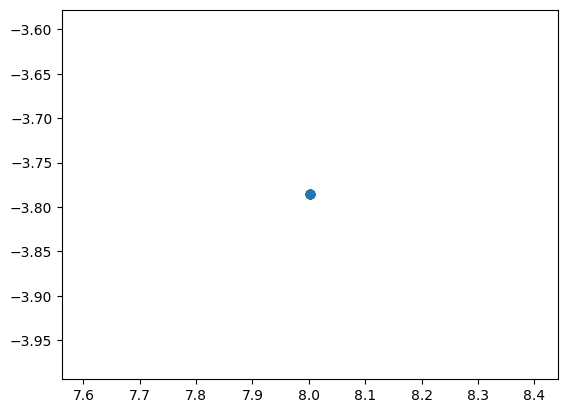

In [162]:
out = g0(c0)
plt.scatter(out[:,0].cpu().detach().numpy(),out[:,1].cpu().detach().numpy())

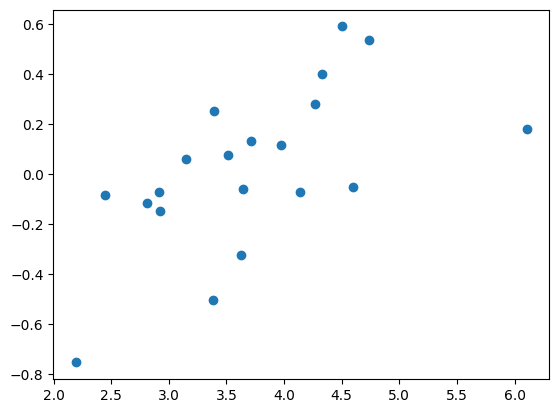

In [163]:
out = g1(c1)
plt.scatter(out[:,0].cpu().detach().numpy(),out[:,1].cpu().detach().numpy())

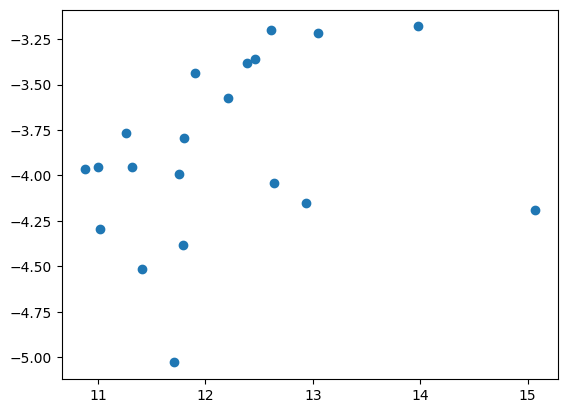

In [169]:
out = g1(c1)+g0(c0)
plt.scatter(out[:,0].cpu().detach().numpy(),out[:,1].cpu().detach().numpy())

In [161]:
c0,c1,x  = all_data.c0[0:20],all_data.c1[0:20],all_data.x[0:20]

In [7]:
class EarlyStopper:
    # https://stackoverflow.com/a/73704579/3361298

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [29]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
N_SEQ = 1
SEQ_LENGTH = 365*2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = 365

FORCING_DIM = 23
OUTPUT_DIM = 1
LATENT_DIM = 4

N_CATCHMENT=1162

EPOCHS = 400
TRAIN_STEPS = round(15*N_CATCHMENT/BATCH_SIZE) # catchment number * year / batch size
VAL_STEP_SIZE = 400

PATIENCE = 25

criterion = nn.MSELoss()

def define_model(trial):
    
    lstm_hidden_dim=trial.suggest_int("lstm_hidden_dim", 4, 128)
    n_lstm_layers=trial.suggest_int("n_lstm_layers", 1, 2)
    n_fc_layers=trial.suggest_int("n_fc_layers", 1, 3)
    p = trial.suggest_float("dropout", 0, 0.5)
    
    fc_hidden_dims = []
    for i in range(n_fc_layers):
        fc_dim = trial.suggest_int(f"fc_dim{i}", 4, 16)
        fc_hidden_dims.append(fc_dim)
        
    decoder = Decoder(
        latent_dim=LATENT_DIM,
        feature_dim=FORCING_DIM,
        lstm_hidden_dim=lstm_hidden_dim,
        fc_hidden_dims=fc_hidden_dims,
        num_lstm_layers=n_lstm_layers,
        output_dim=1,
        p=p,
    )
    
    return decoder


def val_model(embedding, decoder, batch_gen, return_summary = True):
    
    # store predcitions
    preds = np.ones(batch_gen.dataset.y.shape)
    
    for j in range(math.ceil(N_CATCHMENT / VAL_STEP_SIZE)):
        
        # iterate over catchments, evaluate VAL_STEP_SIZE catchments each time
        start_catchment_ind = j * VAL_STEP_SIZE 
        end_catchment_ind = min((j + 1) * VAL_STEP_SIZE, N_CATCHMENT)
        selected_catchments = [a for a in range(start_catchment_ind, end_catchment_ind)]

        x_batch, y_batch = batch_gen.get_batch(selected_catchments=selected_catchments)
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        
        # get the latent code for the catchments
        selected_catchments = torch.from_numpy(np.arange(start_catchment_ind, end_catchment_ind)).to(DEVICE)
        with torch.no_grad():
            code = embedding(selected_catchments)

        # iterate over each year for the selected catchment
        # new shape: year * n_catchments * record length * feature dim
        x_batch = x_batch.transpose(0, 1)
        n_years = x_batch.shape[0]
        for k in range(n_years):
            start_record_ind = BASE_LENGTH + k * TARGET_SEQ_LENGTH
            end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

            # subsetting and pass through decoder
            x_val_sub = x_batch[k, :, :, :].squeeze()
            with torch.no_grad():
                pred = decoder.decode(code, x_val_sub)[:, BASE_LENGTH :]
                preds[
                    start_catchment_ind:end_catchment_ind, start_record_ind:end_record_ind
                ] = (pred.cpu().detach().numpy())

        
        # compuate normalized NSE for each catchment
        # interate over catchments
        gofs = np.ones(preds.shape[0])
        for k in range(preds.shape[0]):
            
            end_record_ind = BASE_LENGTH + n_years * TARGET_SEQ_LENGTH
            y_pred = preds[k, BASE_LENGTH:end_record_ind]
            y_true = batch_gen.dataset.y[k, BASE_LENGTH:end_record_ind].cpu().detach().numpy()

            gofs[k] = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
            
        if return_summary:
            out = gofs.mean()
        else:
            out = gofs
    
    return out
        


def objective(trial):
    
    losses = []
    val_losses = []
    
    # prepare early stopper
    early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0)
    
    # define model
    decoder = define_model(trial).to(DEVICE)
    embedding = nn.Embedding(N_CATCHMENT, LATENT_DIM).to(DEVICE)

    
    # define optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr)
    
    
    # train model
    for epoch in range(EPOCHS):

        running_loss = 0.0

        for i in range(TRAIN_STEPS):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            (xs_batch, ys_batch, selected_catchments) = train_batch_gen.get_batch(
                n_seq=n_seq, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH
            )

            # divide batch and pass to device
            xs_batch, ys_batch, selected_catchments = (
                xs_batch.to(DEVICE),
                ys_batch.to(DEVICE),
                selected_catchments.to(DEVICE),
            )
            
            # slice batch for training
            x0, y0 = (xs_batch[0, :, :, :], ys_batch[0, :, :])
            code = embedding(selected_catchments)

            # pass through decoder
            out = decoder.decode(code, x0)

            # backprop
            loss = criterion(
                out[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :],
                y0[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :],
            )

            loss.backward()
            embedding_optimizer.step()
            decoder_optimizer.step()

            with torch.no_grad():
                running_loss = running_loss + loss.cpu().detach().numpy()

        # put the model in to evaluation model, compute validation loss
        embedding.eval()
        decoder.eval()
        
        val_error = val_model(embedding, decoder, val_batch_gen)
        
        losses.append(running_loss)
        val_losses.append(val_error)
        
        trial.report(val_error, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            torch.cuda.empty_cache()
            raise optuna.exceptions.TrialPruned()
        
        # Early stop using early_stopper, break for loop
        if early_stopper.early_stop(val_error):             
            break
    
    torch.cuda.empty_cache()
    
    return early_stopper.min_validation_loss



In [30]:
# Add stream handler of stdout to show the messages
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "example-study2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name, storage=storage_name,direction="minimize", pruner=optuna.pruners.NopPruner())
study.optimize(objective, n_trials=100)

DuplicatedStudyError: Another study with name 'example-study2' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [12]:
study_name = "example-study2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
loaded_study = optuna.load_study(study_name=study_name, storage=storage_name)

In [13]:
print(loaded_study.best_trial.values)

[0.37800142593031094]


In [14]:
def get_optimal_epochs(loaded_study):
    
    stats = loaded_study.best_trials[0].intermediate_values
    EPOCHS = min(stats, key=lambda k: stats[k]) + 1
    
    return EPOCHS

In [15]:
get_optimal_epochs(loaded_study)

80

In [18]:
def get_final_models(loaded_study):
    
    EPOCHS = get_optimal_epochs(loaded_study)
    trial = loaded_study.best_trials[0]

    losses = []
    val_losses = []
    
    # prepare early stopper
    early_stopper = EarlyStopper(patience=20, min_delta=0)
    
    # define model
    decoder = define_model(trial).to(DEVICE)
    embedding = nn.Embedding(N_CATCHMENT, LATENT_DIM).to(DEVICE)

    
    # define optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr)
    
    
    # train model
    for epoch in range(EPOCHS):

        running_loss = 0.0

        for i in range(TRAIN_STEPS):

            decoder_optimizer.zero_grad()
            embedding_optimizer.zero_grad()

            # put the models into training mode
            decoder.train()
            embedding.train()

            (xs_batch, ys_batch, selected_catchments) = train_batch_gen.get_batch(
                n_seq=n_seq, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH
            )

            # divide batch and pass to device
            xs_batch, ys_batch, selected_catchments = (
                xs_batch.to(DEVICE),
                ys_batch.to(DEVICE),
                selected_catchments.to(DEVICE),
            )
            
            # slice batch for training
            x0, y0 = (xs_batch[0, :, :, :], ys_batch[0, :, :])
            code = embedding(selected_catchments)

            # pass through decoder
            out = decoder.decode(code, x0)

            # backprop
            loss = criterion(
                out[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :],
                y0[:, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :],
            )

            loss.backward()
            embedding_optimizer.step()
            decoder_optimizer.step()

            with torch.no_grad():
                running_loss = running_loss + loss.cpu().detach().numpy()

        # put the model in to evaluation model, compute validation loss
        embedding.eval()
        decoder.eval()
                
        losses.append(running_loss)

    
    torch.cuda.empty_cache()
    
    return embedding, decoder

In [19]:
embedding, decoder = get_final_models(loaded_study)

In [35]:
def val_model(embedding, decoder, batch_gen, gof):
    
    # store predcitions
    preds = np.ones(batch_gen.dataset.y.shape)
    
    for j in range(math.ceil(N_CATCHMENT / VAL_STEP_SIZE)):
        
        # iterate over catchments, evaluate VAL_STEP_SIZE catchments each time
        start_catchment_ind = j * VAL_STEP_SIZE 
        end_catchment_ind = min((j + 1) * VAL_STEP_SIZE, N_CATCHMENT)
        selected_catchments = [a for a in range(start_catchment_ind, end_catchment_ind)]

        x_batch, y_batch = batch_gen.get_batch(selected_catchments=selected_catchments)
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        
        # get the latent code for the catchments
        selected_catchments = torch.from_numpy(np.arange(start_catchment_ind, end_catchment_ind)).to(DEVICE)
        with torch.no_grad():
            code = embedding(selected_catchments)

        # iterate over each year for the selected catchment
        # new shape: year * n_catchments * record length * feature dim
        x_batch = x_batch.transpose(0, 1)
        n_years = x_batch.shape[0]
        for k in range(n_years):
            start_record_ind = BASE_LENGTH + k * TARGET_SEQ_LENGTH
            end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

            # subsetting and pass through decoder
            x_val_sub = x_batch[k, :, :, :].squeeze()
            with torch.no_grad():
                pred = decoder.decode(code, x_val_sub)[:, BASE_LENGTH :]
                preds[
                    start_catchment_ind:end_catchment_ind, start_record_ind:end_record_ind
                ] = (pred.cpu().detach().numpy())

        
        # compuate normalized NSE for each catchment
        # interate over catchments
        gofs = np.ones(preds.shape[0])
        for k in range(preds.shape[0]):
            
            end_record_ind = BASE_LENGTH + n_years * TARGET_SEQ_LENGTH
            y_pred = preds[k, BASE_LENGTH:end_record_ind]
            y_true = batch_gen.dataset.y[k, BASE_LENGTH:end_record_ind].cpu().detach().numpy()

            gofs[k] = gof(y_true=y_true, y_pred=y_pred)
    
    return gofs

In [28]:
val_error = val_model(embedding, decoder, val_batch_gen, r2_score)
val_error

0.43720305465326126

In [39]:
test_error = val_model(embedding, decoder, test_batch_gen, r2_score)
test_error =1/(2-test_error)

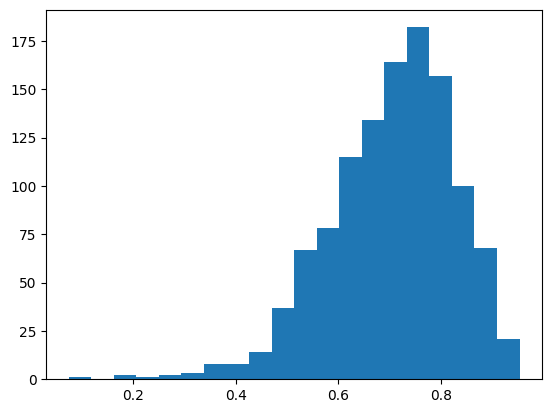

In [40]:
plt.hist(test_error, bins = 20)
plt.show()


In [114]:
for j in range(math.ceil(N_CATCHMENT / 100)):
    # iterate over catchment
    start_catchment_ind = j * 100  # evaluate 100 catchments each time
    end_catchment_ind = min((j + 1) * 100, N_CATCHMENT)

    x_val, y_val = val_batch_gen.get_batch(
        selected_catchments=[
            a for a in range(start_catchment_ind, end_catchment_ind)
        ]
    )
    
    x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)

    code = embedding(
        torch.from_numpy(np.arange(start_catchment_ind, end_catchment_ind)).to(DEVICE)
    )

    x_val = x_val.transpose(0, 1)

    for k in range(x_val.shape[0]):
        # iterate over each year
        start_record_ind = (k + 1) * (SEQ_LENGTH - TARGET_SEQ_LENGTH)
        end_record_ind = start_record_ind + TARGET_SEQ_LENGTH

        x_val_sub = x_val[k, :, :, :].squeeze()
        preds[
            start_catchment_ind:end_catchment_ind,
            start_record_ind:end_record_ind,
        ] = decoder.decode(code, x_val_sub)[
            :, (SEQ_LENGTH - TARGET_SEQ_LENGTH) :
        ]


(array([0.43717647, 0.43784574, 0.43842176, ..., 0.43535876, 0.4355703 ,
        0.43591914], dtype=float32),
 array([0.43717647, 0.43784574, 0.43842176, ..., 0.43535876, 0.4355703 ,
        0.43591914], dtype=float32))

In [111]:
preds[start_catchment_ind:end_catchment_ind, start_record_ind:end_record_ind]

tensor([[0.4298, 0.4280, 0.4264,  ..., 0.4321, 0.4302, 0.4300],
        [0.4271, 0.4259, 0.4248,  ..., 0.4288, 0.4275, 0.4269],
        [0.4300, 0.4291, 0.4280,  ..., 0.4304, 0.4289, 0.4291],
        ...,
        [0.4322, 0.4332, 0.4337,  ..., 0.4338, 0.4342, 0.4346],
        [0.4313, 0.4320, 0.4323,  ..., 0.4328, 0.4330, 0.4332],
        [0.4328, 0.4338, 0.4344,  ..., 0.4354, 0.4356, 0.4359]],
       grad_fn=<SliceBackward0>)

In [115]:
preds = torch.ones(val_batch_gen.dataset.y.shape)
preds

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

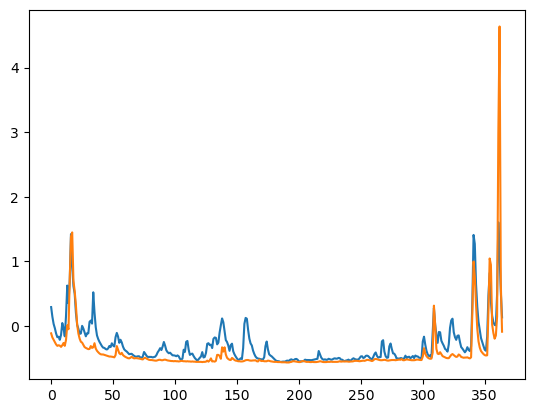

In [29]:
with torch.no_grad():
        (xs_batch, ys_batch, selected_catchments) = train_batch_gen.get_batch(
            n_seq=n_seq, batch_size=BATCH_SIZE, seq_length=SEQ_LENGTH
        )
        
        # divide batch and pass to device

        xs_batch, ys_batch, selected_catchments = xs_batch.to(DEVICE), ys_batch.to(DEVICE), selected_catchments.to(DEVICE)
        
        x0, y0 = (
            xs_batch[0, :, :, :],
            ys_batch[0, :, :]
        )

        code = embedding(selected_catchments)

        # pass through decoder
        out = decoder.decode(code, x0).squeeze()
    
data_plot = out.cpu().detach().numpy()

plt.plot(data_plot[1, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])
plt.plot(y0[1, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy())

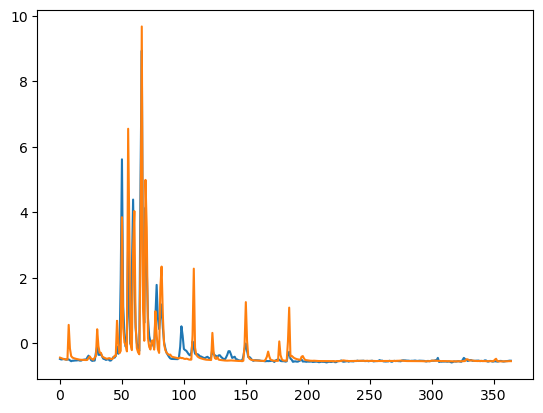

In [30]:
plt.plot(data_plot[24, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])
plt.plot(y0[24, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy())

In [31]:
r2_score(y_true=y0[24, (SEQ_LENGTH-TARGET_SEQ_LENGTH):].cpu().detach().numpy(), y_pred=data_plot[24, (SEQ_LENGTH - TARGET_SEQ_LENGTH) : ])

0.7751805182474258

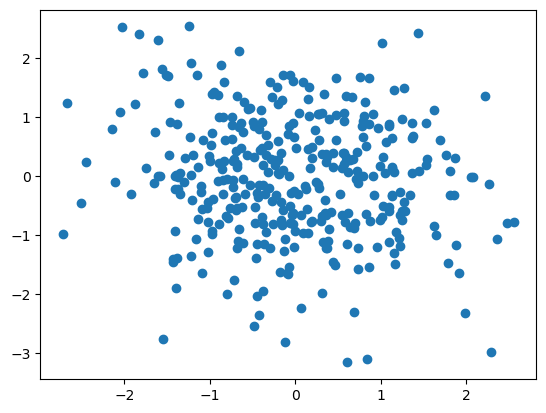

In [15]:
plt.scatter(code[:,0].cpu().detach().numpy(), code[:,1].cpu().detach().numpy())

In [16]:
torch.save(embedding, "data/Caravan/embedding.pt")
torch.save(decoder, "data/Caravan/decoder.pt")